# Matriz Moran Brasil

Para fazer commit: `Ctrl + Shift + m`   
Reposotório: `spatial_cluster`   
Caminho do arquivo: `scripts/sul/matriz_moran_brasil.ipynb`

## Bibliotecas

In [2]:
!pip install geopandas==0.8.1
!pip install --upgrade pyshp
!pip install shapely==1.7.0
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
!pip install jenkspy
!pip install pyshp

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches, colors
from matplotlib.lines import Line2D
from matplotlib.collections import EventCollection
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection  
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from libpysal import weights
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para agrupamento - K-médias
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans

# para avaliar grupos 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix

import warnings
warnings.filterwarnings("ignore")

import shapefile
from google.colab import drive, files

In [4]:
drive.mount("/content/drive")

Mounted at /content/drive


## Funções

In [5]:
def plot_dendrogram(model, max_d=0):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    fig, ax = plt.subplots(figsize=(15, 7))
    ax = dendrogram(linkage_matrix,
                    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
                    p=5,  # quantos passos mostrar
                    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
                    leaf_rotation=90., # rotação
                    leaf_font_size=10., # tamanho da fonte
                    labels=dados.index, # rótulos do eixo x
                    show_contracted=True,  # to get a distribution impression in truncated branches,
                    above_threshold_color='black',
                    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
                    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
                    )
    plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
    plt.xlabel('Município')
    plt.ylabel('Distância');

In [6]:
def moran_hot_cold_spots(moran_loc, p=0.05):
    sig = 1 * (moran_loc.p_sim < p)
    HH = 1 * (sig * moran_loc.q == 1)
    LL = 3 * (sig * moran_loc.q == 3)
    LH = 2 * (sig * moran_loc.q == 2)
    HL = 4 * (sig * moran_loc.q == 4)
    cluster = HH + LL + LH + HL
    return cluster

In [7]:
def mask_local_auto(moran_loc, p=0.5):
    
    # create a mask for local spatial autocorrelation
    cluster = moran_hot_cold_spots(moran_loc, p)

    cluster_labels = ['não significativo', 'AA', 'BA', 'BB', 'AB']
    labels = [cluster_labels[i] for i in cluster]

    colors5 = {0: 'lightgrey',
               1: '#fde725', # #d7191c
               2: '#21918c', # #abd9e9
               3: '#3b528b', # #2c7bb6
               4: '#5ec962'} # #fdae61
    colors = [colors5[i] for i in cluster]  # for Bokeh
    # for MPL, keeps colors even if clusters are missing:
    x = np.array(labels)
    y = np.unique(x)

    colors5_mpl = {'AA': '#fde725', # #d7191c 
                   'BA': '#21918c', # #abd9e9
                   'BB': '#3b528b', # #2c7bb6 
                   'AB': '#5ec962', # #fdae61 
                   'não significativo': 'lightgrey'}  # 
    colors5 = [colors5_mpl[i] for i in y]  # for mpl

    # HACK need this, because MPL sorts these labels while Bokeh does not
    cluster_labels.sort()
    return cluster_labels, colors5, colors, labels

def lisa_cluster(moran_loc, gdf, p=0.05, ax=None,
                 legend=True, legend_kwds=None, **kwargs):

    # retrieve colors5 and labels from mask_local_auto
    _, colors5, _, labels = mask_local_auto(moran_loc, p=p)

    # define ListedColormap
    hmap = colors.ListedColormap(colors5)

    if ax is None:
        figsize = kwargs.pop('figsize', None)
        fig, ax = plt.subplots(1, figsize=figsize)
    else:
        fig = ax.get_figure()

    gdf.assign(cl=labels).plot(column='cl', categorical=True,
                               k=2, cmap=hmap, linewidth=0, ax=ax,
                               edgecolor='white', legend=False, # tirei a legenda aqui 
                               legend_kwds=legend_kwds, **kwargs)
    ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.3)) # Adiciona linha dos estados 
    ax.set_axis_off()
    ax.set_aspect('equal')
    return fig, ax

## Dados

In [8]:
link = 'https://raw.githubusercontent.com/walefmachado/spreg_rural_insurance/main/dados/'

### Dados de seguro rural

In [9]:
dados_br = pd.read_csv(link+'/dados_06_19.csv')

### Dados para espacial 

In [10]:
cod = pd.read_csv(link+'/codigos-mun.csv')

In [11]:
br = geopandas.read_file(link+'/br.json')

In [12]:
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [13]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [14]:
dados_br = cod_dados.merge(dados_br, on='mun', how='left')

In [15]:
dados_br = dados_br.fillna(0)
#dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['rm'], axis = 1)

In [16]:
dados_br.rename(columns = {'nome_mun_x': 'nome_mun', 'nome_meso_x':'nome_meso'}, inplace = True)

In [17]:
retirar = ['nome_mun_y', 'nome_meso_y']
dados_br = dados_br.drop(retirar, axis = 1)

In [18]:
img=mpimg.imread('/content/drive/My Drive/Mestrado/Imagens/rosa_dos_ventos_3.png')
img2=mpimg.imread('/content/drive/My Drive/Mestrado/Imagens/rosa_dos_ventos_p.png')

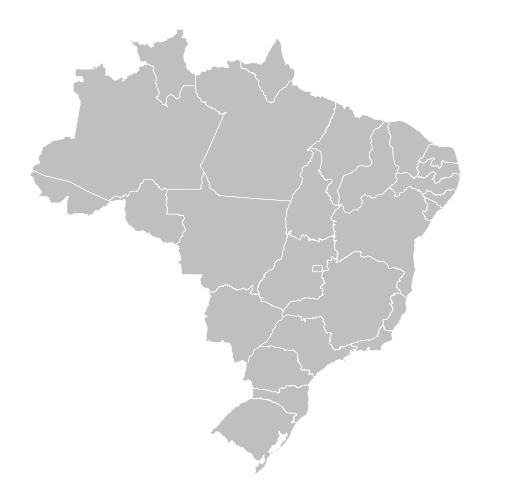

In [19]:
#Regioes geograficas
sf = shapefile.Reader('/content/drive/My Drive/Mestrado/Dados/estados/estados_2010.shp')
shapes = sf.shapes()
Nshp = len(shapes)

ptchs   = []
for nshp in range(Nshp):
    pts     = np.array(shapes[nshp].points)
    prt     = shapes[nshp].parts
    par     = list(prt) + [pts.shape[0]]

    for pij in range(len(prt)):
       ptchs.append(Polygon(pts[par[pij]:par[pij+1]]))

#UF
sf_uf = shapefile.Reader('/content/drive/My Drive/Mestrado/Dados/estados/estados_2010.shp')
shapes = sf.shapes()
shapes_uf = sf_uf.shapes()
Nshp_uf = len(shapes_uf)

ptchs_uf   = []
for nshp_uf in range(Nshp_uf):
    pts_uf     = np.array(shapes_uf[nshp_uf].points)
    prt_uf     = shapes_uf[nshp_uf].parts
    par_uf     = list(prt_uf) + [pts_uf.shape[0]]

    for pij_uf in range(len(prt_uf)):
       ptchs_uf.append(Polygon(pts_uf[par_uf[pij_uf]:par_uf[pij_uf+1]]))


fig     = plt.figure(figsize = (9,9))
ax      = fig.add_subplot(111)

ax.add_collection(PatchCollection(ptchs,facecolor='0.75', edgecolor='w', linewidths=0))
ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))
ax.axis('auto'); ax.axis('off')
plt.show()
# Fonte: http://www.phme.it/wilt/2017/05/06/dynamic-mapping-with-shapefiles-and-python/

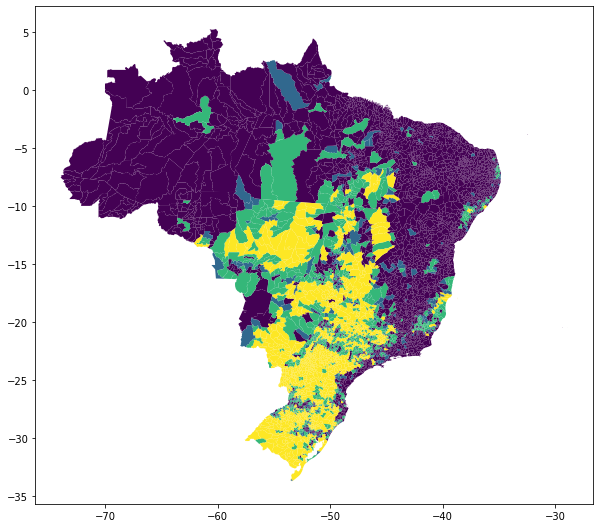

In [ ]:
dados_br[dados_br['ano']==2019].plot(column='apolices_contratadas', figsize=(10, 10), cmap='viridis', scheme='quantiles')

In [20]:
variaveis = ['apolices_contratadas', 'total_segurado_mil', 'soma_premio_total_mil',
             'total_subvencao_mil', 'valor_indenizacoes_pagas_mil',
             'sinistralidade_media', 'taxa_media', 'apolices_indenizadas'] # 
anos = dados_br.ano.unique()

In [21]:
dados_br = dados_br.rename({'apolices_contratadas':'TAC',
                            'total_segurado_mil':'SIS',
                            'soma_premio_total_mil':'SPR',
                            'total_subvencao_mil':'TSB',
                            'valor_indenizacoes_pagas_mil':'SIP',
                            'taxa_media':'TMA',
                            'apolices_indenizadas':'NAI'}, axis=1)
#variaveis = ['apolices_contratadas', 'total_segurado_mil', 'soma_premio_total_mil', 'total_subvencao_mil', 'valor_indenizacoes_pagas_mil', 'taxa_media', 'apolices_indenizadas']
variaveis = ['TAC', 'SIS', 'SPR', 'TSB', 'SIP', 'TMA', 'NAI']

In [22]:
dados_19 = dados_br[dados_br['ano']==2019]
dados_19.drop('ano', axis=1, inplace=True)

## Matriz de I de Moran 

Teste de construção de uma matriz de I de Moran para cada variável


### Criando a matriz

In [23]:
dados_19.drop(index=dados_19[dados_19['mun'] == 2605459].index, inplace=True) # retira F. Noronha e Ilhabela
dados_19.drop(index=dados_19[dados_19['mun'] == 3520400].index, inplace=True) 

In [24]:
getis_matrix = dados_19

In [25]:
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao'] # , 'geometry'
getis_matrix = getis_matrix.drop(retirar, axis = 1)

In [26]:
moran_matrix = dados_19
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao', 'cod_uf','sinistralidade_media'] # , 'geometry'
moran_matrix = moran_matrix.drop(retirar, axis = 1)

### I de Moran local para variáveis

In [27]:
moran_matrix.columns

Index(['nome_mun', 'geometry', 'TAC', 'SIS', 'SPR', 'TSB', 'SIP', 'TMA',
       'NAI'],
      dtype='object')

In [28]:
# demora um pouco
w = Queen.from_dataframe(dados_19)
w.transform = 'r'

In [29]:
for variavel in moran_matrix.drop(['nome_mun', 'geometry'], axis = 1).columns:
    moran_matrix[variavel] = Moran_Local(dados_19[variavel].values, w).Is

In [30]:
moran_matrix = moran_matrix.set_index('nome_mun')

In [31]:
moran_matrix.describe()

,TAC,SIS,SPR,TSB,SIP,TMA,NAI
count,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000
mean,0.636154,0.520119,0.505555,0.510070,0.371433,0.802696,0.500635
std,4.469158,3.179503,3.404342,3.463193,3.191286,3.301044,3.624815
min,-0.938072,-0.989530,-0.975729,-0.916440,-1.701300,-0.980963,-1.559970
25%,0.046820,0.050408,0.047438,0.047525,0.042375,0.075148,0.042952
50%,0.081035,0.091493,0.073848,0.074095,0.048025,0.154090,0.048967
75%,0.082241,0.092302,0.074253,0.074502,0.048025,0.156137,0.048967
max,161.264063,67.141709,85.098225,90.282537,126.269271,64.513471,102.088421


### Mapa I de Moran

In [ ]:
# cria a legenda LISA
labels = ['AA', 'AB', 'BA', 'BB', 'não significativo']
#color_list = ["#d7191c", "#abd9e9", "#2c7bb6", "#fdae61", "lightgrey"]
color_list = ["#fde725", "#5ec962", "#21918c", "#3b528b", "lightgrey"]

hmap = colors.ListedColormap("", color_list)
lines = [Line2D([0], [0], color=c, marker='o', markersize=25, linestyle='') for c in color_list] # linewidth=20, linestyle='dotted'

In [ ]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 20)) 
axs = axs.flatten()
for i, variavel in enumerate(variaveis):
    ax = axs[i]
    y = dados_19[variavel].values 
    moran_loc_br = Moran_Local(y, w)
    lisa_cluster(moran_loc_br, dados_19, p=0.05, ax=ax)
    #moran_matrix.plot(column=variavel, ax=ax, legend=True, scheme='quantiles', cmap = 'viridis'); # , cmap='OrRd'  scheme='quantiles',
    ax.set_axis_off()
    ax.set_title(variavel, fontsize=25)
    f.tight_layout() 
    ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))   # adiciona a divisão estadual
axs[7].legend(lines, labels, loc='botton left', bbox_to_anchor=(1.7, 0.75), frameon=False,  prop={'size': 20})
axs[7].set_axis_off()
axs[8].set_axis_off()
axs[7].imshow(img)
plt.subplots_adjust(left=7, bottom=7, right=8, top=8, wspace=0.0005, hspace=0.001)
plt.show();

In [ ]:
f, ax = plt.subplots(figsize=(16,16)) # 
moran_matrix.plot(column='apolices_contratadas', ax=ax, figsize=(10, 10), cmap = 'viridis', scheme='quantiles'); # , cmap='OrRd'
ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.3))
ax.set_axis_off()
plt.figimage(img2, 720, 25, zorder=1)
plt.show();

## Análise de agrupamento - I de Moran

In [32]:
# subselecionar variáveis
X = moran_matrix.drop('geometry', axis=1)
# transformar em matriz (necessário para gerar o gráfico)
XX = X.values
# mudar o tipo dos dados
XX = np.asarray(XX, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [33]:
Z = linkage(X, method='ward')

In [34]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

In [35]:
import sys
print(sys.getrecursionlimit())
# sys.setrecursionlimit(2000)

1000


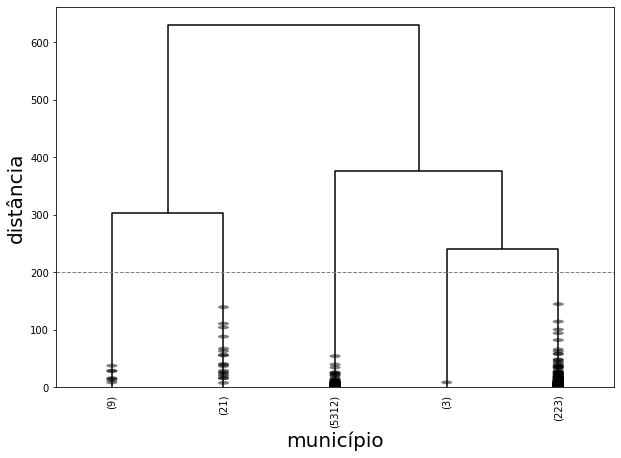

In [44]:
fig, ax = plt.subplots(figsize=(10, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados_19.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município', fontsize=20)
plt.ylabel('distância', fontsize=20);

**Método escolhido:** 

In [37]:
Z = linkage(X, method='ward')

In [60]:
# definir a distância de corte baseando no dendrograma
max_d = 230
grupos = cut_tree(Z, height=max_d)

In [61]:
  # incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
moran_matrix['grupo'] = grupos
# moran_matrix.head(2)

In [62]:
dados_19['grupo'] = grupos

In [63]:
dados_19.grupo.value_counts()

0    5312
1     223
2      21
3       9
4       3
Name: grupo, dtype: int64

In [64]:
pd.options.display.float_format = '{:20,.2f}'.format

In [65]:
dados_19.groupby('grupo').mean().round(2).drop(['cod_uf', 'mun', 'meso', 'micro', 'codmun6', 'regiao', 'sinistralidade_media'], axis=1)#.to_latex()

,TAC,SIS,SPR,TSB,SIP,TMA,NAI
grupo,,,,,,,
0,7.68,"1,892,193.38","105,276.81","36,532.61","29,693.40",0.15,0.68
1,173.36,"32,377,896.41","2,152,607.72","748,847.23","556,841.71",2.31,16.93
2,569.57,"71,902,577.63","5,226,774.92","1,815,377.27","1,454,607.57",3.87,68.71
3,344.89,"124,095,719.64","11,129,426.06","3,870,037.04","1,407,619.53",2.36,20.22
4,117.67,"58,773,616.53","4,980,581.99","1,655,144.56","4,453,559.68",2.28,26.00


In [66]:
# contagem de observações em cada grupo
moran_matrix.grupo.value_counts()

0    5312
1     223
2      21
3       9
4       3
Name: grupo, dtype: int64

In [68]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
moran_matrix.groupby('grupo').mean().round(2).to_latex()

'\\begin{tabular}{lrrrrrrr}\n\\toprule\n{} &                  TAC &                  SIS &                  SPR &                  TSB &                  SIP &                  TMA &                  NAI \\\\\ngrupo &                      &                      &                      &                      &                      &                      &                      \\\\\n\\midrule\n0     &                 0.11 &                 0.12 &                 0.09 &                 0.09 &                 0.08 &                 0.26 &                 0.11 \\\\\n1     &                 7.50 &                 6.18 &                 5.43 &                 5.48 &                 3.91 &                11.15 &                 5.68 \\\\\n2     &                55.71 &                21.25 &                23.71 &                23.66 &                16.12 &                25.49 &                43.24 \\\\\n3     &                14.16 &                44.68 &                62.54 &           

In [ ]:
# mediana das variáveis para cada grupo
moran_matrix.groupby('grupo').median()

,TAC,SIS,SPR,TSB,SIP,TMA,NAI
grupo,,,,,,,
0,0.080632,0.090686,0.073280,0.073513,0.048025,0.151800,0.048967
1,5.347203,4.020815,3.747967,3.825838,1.554114,10.477247,2.388497
2,49.169796,17.085879,20.224419,20.663597,11.156050,25.957034,40.584401
3,17.554665,44.842991,59.916725,57.692233,13.001547,7.808701,4.066766
4,1.232086,9.894737,15.822553,14.148270,88.892249,6.415968,5.243536


### As observações de cada grupo


In [ ]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com I de Moran

In [ ]:
moran_matrix['grupo'] = moran_matrix['grupo'].astype('category')

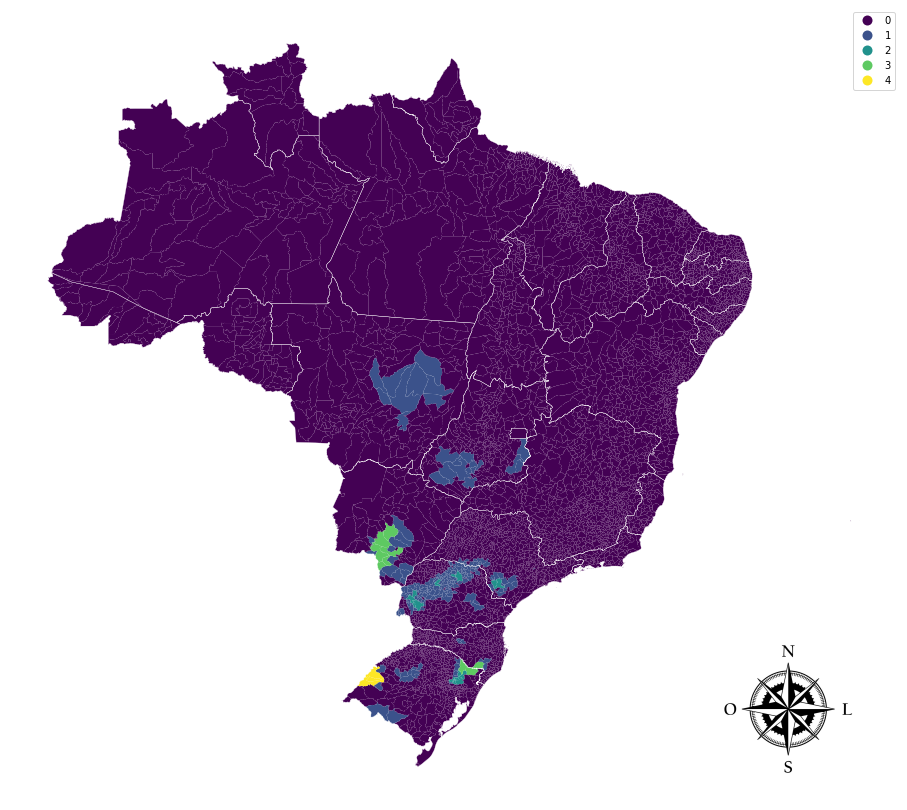

In [ ]:
f, ax = plt.subplots(figsize=(16,16)) # 
moran_matrix.plot(column='grupo', figsize=(10, 10), legend=True, ax=ax, cmap='viridis'); # , cmap='OrRd'
ax.set_axis_off()
ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.3))
plt.figimage(img2, 720, 25, zorder=1)
plt.show();



## K-Médias - I de Moran


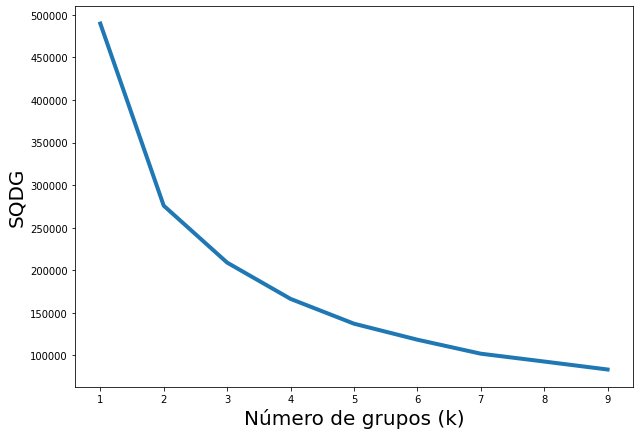

In [ ]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(moran_matrix.drop('geometry', axis=1))
    moran_matrix['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure(figsize=(10, 7))
plt.plot(list(SQDG.keys()), list(SQDG.values()), linewidth=4)
plt.xlabel('Número de grupos (k)', fontsize = 20)
plt.ylabel('SQDG', fontsize = 20);

In [ ]:
k = 5

In [ ]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

In [ ]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
moran_matrix['grupo'] = kmeans.labels_

In [ ]:
# contagens
moran_matrix.grupo.value_counts()

0    5380
2     158
3      15
4      10
1       5
Name: grupo, dtype: int64

In [ ]:
dados_19['grupo'] = kmeans.labels_

In [ ]:
dados_19.groupby('grupo').mean().round(2).drop(['cod_uf', 'mun', 'meso', 'micro', 'codmun6', 'regiao', 'sinistralidade_media'], axis=1).to_latex()

'\\begin{tabular}{lrrrrrrr}\n\\toprule\n{} &                  TAC &                  SIS &                  SPR &                  TSB &                  SIP &                  TMA &                  NAI \\\\\ngrupo &                      &                      &                      &                      &                      &                      &                      \\\\\n\\midrule\n0     &                 9.00 &         2,210,399.50 &           125,163.46 &            43,435.23 &            32,044.65 &                 0.17 &                 0.75 \\\\\n1     &               192.60 &        53,892,341.69 &         4,446,303.68 &         1,499,628.28 &         4,243,046.92 &                 3.00 &                61.20 \\\\\n2     &               205.80 &        34,675,760.99 &         2,351,545.91 &           818,622.42 &           690,872.13 &                 2.60 &                22.08 \\\\\n3     &               640.93 &        80,999,520.67 &         5,967,192.65 &         2,

In [ ]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
moran_matrix.groupby('grupo').mean().round(2).to_latex()

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n{} &    TAC &    SIS &    SPR &    TSB &    SIP &    TMA &    NAI &  grupos \\\\\ngrupo &        &        &        &        &        &        &        &         \\\\\n\\midrule\n0     &   0.14 &   0.17 &   0.13 &   0.13 &   0.09 &   0.32 &   0.12 &    0.05 \\\\\n1     &   6.23 &   8.65 &  12.17 &  11.43 &  82.02 &  14.88 &  25.84 &    4.00 \\\\\n2     &  10.29 &   7.06 &   6.39 &   6.46 &   5.15 &  13.60 &   8.27 &    4.56 \\\\\n3     &  65.42 &  25.53 &  29.04 &  28.90 &  13.88 &  28.56 &  45.68 &    3.53 \\\\\n4     &  13.62 &  43.16 &  59.62 &  61.16 &  13.41 &   7.54 &   4.45 &    2.20 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
moran_matrix.columns

Index(['geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas', 'grupo', 'grupos'],
      dtype='object')

In [ ]:
pd.options.display.float_format = '{:20,.2f}'.format
resumo_estatistico = moran_matrix.groupby('grupo').mean().drop(['apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil','grupos'],axis=1)
print(resumo_estatistico.to_latex(index=True))  

In [ ]:
pd.options.display.float_format = '{:20,.2f}'.format
resumo_estatistico = moran_matrix.groupby('grupo').mean().drop(['grupos','valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],axis=1)
print(resumo_estatistico.to_latex(index=True))  

In [ ]:
# mediana das variáveis para cada grupo
moran_matrix.groupby('grupo').median()

NameError: ignored

In [ ]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com I de Moran

In [ ]:
moran_matrix['grupo'] = moran_matrix['grupo'].astype('category')

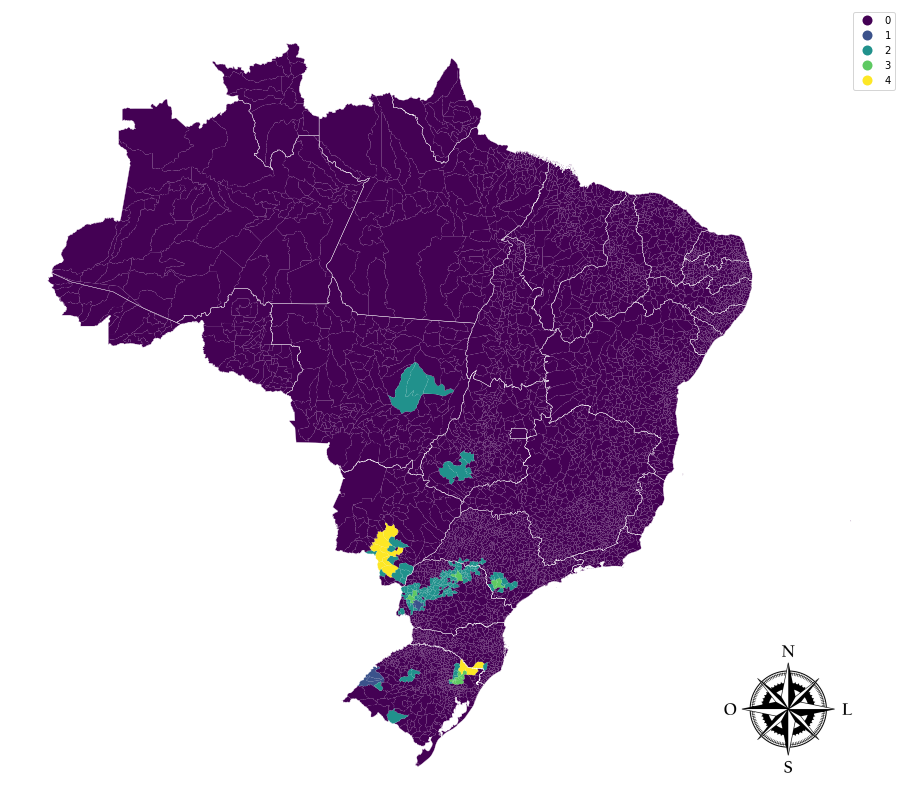

In [ ]:
f, ax = plt.subplots(figsize=(16,16)) # 
moran_matrix.plot(column='grupo', figsize=(10, 10), legend=True, ax=ax, cmap='viridis'); # , cmap='OrRd'
ax.set_axis_off()
ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.3))
plt.figimage(img2, 720, 25, zorder=1)
plt.show();


## KDE plot

In [ ]:
dados_plots = moran_matrix.drop(['geometry', 'grupos'], axis = 1)

In [ ]:
tidy_db = dados_plots.set_index('grupo')
# Keep only variables used for clustering
#tidy_db = tidy_db[cluster_variables]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Variável', 
                        0: 'Valores'})
# Check out result
tidy_db.head()

,grupo,Variável,Valores
0,0,apolices_contratadas,0.08
1,0,total_segurado_mil,0.08
2,0,soma_premio_total_mil,0.06
3,0,total_subvencao_mil,0.06
4,0,valor_indenizacoes_pagas_mil,0.04


In [ ]:
import seaborn

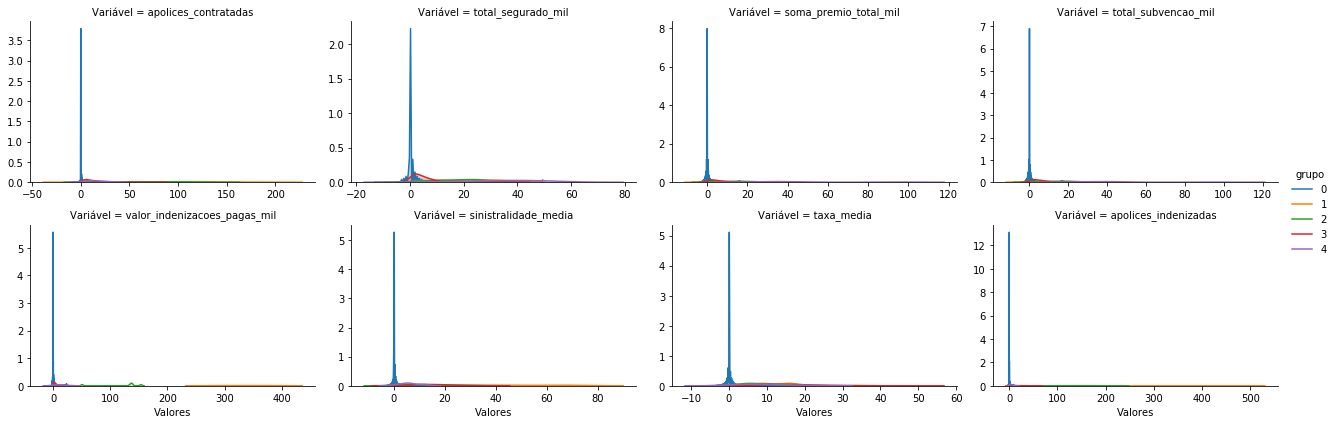

In [ ]:
# Setup the facets
facets = seaborn.FacetGrid(data=tidy_db, col='Variável', hue='grupo', \
                  sharey=False, sharex=False, aspect=1.5, col_wrap=4)
# Build the plot from `sns.kdeplot`
_ = facets.map(seaborn.kdeplot, 'Valores', shade=True).add_legend()